In [1]:
import icarogw
from icarogw.cupy_pal import *
import matplotlib.pyplot as plt
import numpy as np
import corner
import h5py
from astropy.cosmology import Planck15
import pickle
import scipy

Config file loaded
CUPY NOT LOADED


# Default model test



In [2]:
# Download the  posteriors for the injections 
data=h5py.File('endo3_bbhpop-LIGO-T2100113-v12.hdf5')

# Build the cosmology using z_max=10 and the Planck2015 cosmo params
cosmo_ref=icarogw.cosmology.astropycosmology(10)
cosmo_ref.build_cosmology(Planck15)

# Compute the IFAR max from all the pipelines
ifarmax=np.vstack([data['injections'][key] for key in ['ifar_cwb', 'ifar_gstlal', 'ifar_mbta', 'ifar_pycbc_bbh', 'ifar_pycbc_hyperbank']])
ifarmax=np.max(ifarmax,axis=0)

# Time of observation for O3a
time_O3 = (28519200/86400)/365 


amax=0.998

# Spin prior for chi_1,chi_2,cos_t_1,cos_t_2 , uniform in magnitude and istropic
spinp= (1./amax)*(1./amax)*0.5*0.5

# Full prior used by PE (spin, masses, redshift) transformed in the det frame
prior=np2cp(data['injections/mass1_source_mass2_source_sampling_pdf'][()]*data['injections/redshift_sampling_pdf'][()])*spinp
prior*=icarogw.conversions.source2detector_jacobian(np2cp(data['injections/redshift'][()]),cosmo_ref)



In [3]:
# Compute the values of chi1,2 cost1,2 using the carthesians values from the injections
chi_1, chi_2, cos_t_1, cos_t_2, chi_eff, chi_p = icarogw.conversions.cartestianspins2chis(data['injections/spin1x'][()],data['injections/spin1y'][()],data['injections/spin1z'][()],
                                           data['injections/spin2x'][()],data['injections/spin2y'][()],data['injections/spin2z'][()],
                                           data['injections/mass2_source'][()]/data['injections/mass1_source'][()])



In [4]:
# Construct the injection dictionnary
injections_dict={'mass_1':data['injections/mass1'][()],'mass_2':data['injections/mass2'][()],
                'luminosity_distance':data['injections/distance'][()],
                'chi_1':chi_1,'chi_2':chi_2,'cos_t_1':cos_t_1,'cos_t_2':cos_t_2}
inj=icarogw.injections.detector_injections_CBC(injections_dict,prior=prior,ntotal=data.attrs['total_generated'],Tobs=time_O3)

#Update the cut of the injections
inj.update_cut(ifarmax>=4)
inj.cupyfy()



In [5]:
# Import the posterior samples of BBH during O3a + O3b and IFAR4
poss=pickle.load(open('O3a_O3b_BBH_IFAR4.p','rb'))

posterior_dict={}
for ev in poss.keys():
    pos_dict={'mass_1':poss[ev]['mass_1_det'],'mass_2':poss[ev]['mass_2_det'],
             'luminosity_distance':poss[ev]['distance'],
             'right_ascension':poss[ev]['right_ascension'],'declination':poss[ev]['declination'],
             'chi_1':poss[ev]['chi_1'],'chi_2':poss[ev]['chi_2'],'cos_t_1':poss[ev]['cost_1'],
             'cos_t_2':poss[ev]['cost_2']}
    posterior_dict[ev]=icarogw.posterior_samples.posterior_samples(pos_dict,
                                                                         prior=np.power(poss[ev]['distance'],2.))

print(posterior_dict.keys())

dict_keys(['GW190408_181802', 'GW190412', 'GW190413_134308', 'GW190421_213856', 'GW190503_185404', 'GW190512_180714', 'GW190513_205428', 'GW190517_055101', 'GW190519_153544', 'GW190521', 'GW190521_074359', 'GW190527_092055', 'GW190602_175927', 'GW190620_030421', 'GW190630_185205', 'GW190701_203306', 'GW190706_222641', 'GW190707_093326', 'GW190708_232457', 'GW190720_000836', 'GW190727_060333', 'GW190728_064510', 'GW190803_022701', 'GW190828_063405', 'GW190828_065509', 'GW190910_112807', 'GW190915_235702', 'GW190924_021846', 'GW190925_232845', 'GW190929_012149', 'GW190930_133541', 'GW191105_143521', 'GW191109_010717', 'GW191127_050227', 'GW191129_134029', 'GW191204_171526', 'GW191215_223052', 'GW191216_213338', 'GW191222_033537', 'GW191230_180458', 'GW200112_155838', 'GW200128_022011', 'GW200129_065458', 'GW200202_154313', 'GW200208_130117', 'GW200209_085452', 'GW200219_094415', 'GW200224_222234', 'GW200225_060421', 'GW200302_015811', 'GW200311_115853', 'GW200316_215756'])


In [6]:
print(posterior_dict['GW190408_181802'])


In [7]:
# Creates each empty model using wrappers:

# Cosmo
cw=icarogw.wrappers.FlatLambdaCDM_wrap(zmax=10.)
# Masses
mw=icarogw.wrappers.massprior_PowerLawPeak()
# Redshift
rw=icarogw.wrappers.rateevolution_Madau()
# Spins
sw=icarogw.wrappers.spinprior_default()

likelihood=icarogw.likelihood.hierarchical_likelihood_CBC_source(posterior_dict,inj,cw,mw,rw,spin_wrap=sw
                                                                  ,scale_free=True,neffINJ=200,neffPE=-1)

Using 3194 samples from each 52 posteriors


(2.2412, 6.378799999999999)
(0.17142857142857143, 0.01235137533274179)


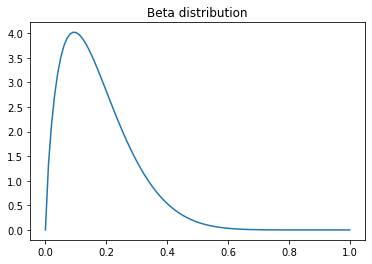

In [8]:
print(icarogw.priors.betadistro_muvar2ab(0.26,0.02))
print(icarogw.priors.betadistro_ab2muvar(1.8,8.7))

x_pdf = np.linspace(0,1,100)
plt.title('Beta distribution')
plt.plot(x_pdf,scipy.stats.beta.pdf(x_pdf, 1.8,8.7, loc=0, scale=1))

/Users/pierra/Desktop/These_ip2i/Cosmology_researches/icaroGW/icarogw_2/icarogwCAT_folder/icarogw/priors.py:44: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = xp.exp(xp.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select_window]-delta_m))))
/Users/pierra/Desktop/These_ip2i/Cosmology_researches/icaroGW/icarogw_2/icarogwCAT_folder/icarogw/priors.py:305: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_pdf(x)+xp.log(window)-xp.log(self.norm)
/Users/pierra/Desktop/These_ip2i/Cosmology_researches/icaroGW/icarogw_2/icarogwCAT_folder/icarogw/priors.py:332: RuntimeWarning: divide by zero encountered in log
  return xp.log(toret).reshape(origin)
/Users/pierra/Desktop/These_ip2i/Cosmology_researches/icaroGW/icarogw_2/icarogwCAT_folder/icarogw/priors.py:217: RuntimeWarning: invalid value encountered in subtract
  y=self.pdf1.log_pdf(x1)+self.pdf2.log_pdf(x2)-self.pdf2.log_cdf(x1)


Text(0, 0.5, 'Posterior')

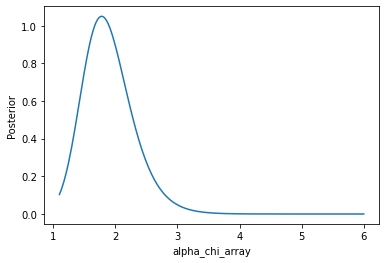

In [9]:
alpha_chi_array=np.linspace(1.1,6,200)
posterior_alpha=np.zeros_like(alpha_chi_array)

# Number of effective samples for each events
neffinj=np.zeros_like(alpha_chi_array)

for i,muu in enumerate(alpha_chi_array):
    likelihood.parameters={'H0':70.,'Om0':0.3,
                           'alpha':1.,'beta':1.,'mmin':5.,'mmax':90.,'delta_m':4.,'mu_g':33.,'sigma_g':5.,'lambda_peak':0.03,
                          'gamma':2.7,'zp':2.,'kappa':3.,
                          'alpha_chi':muu,'beta_chi':6.37,'sigma_t':0.87,'csi_spin':0.76}
    posterior_alpha[i]=likelihood.log_likelihood()
    
    # Storing the value of effective samples for the i-th event
    neffinj[i]=likelihood.injections.effective_detection_number(likelihood.injections.weights)
    
    
    
posterior_alpha-=posterior_alpha.max()
posterior_alpha=xp.exp(posterior_alpha)
posterior_alpha/=trapz(posterior_alpha,alpha_chi_array)
plt.plot(alpha_chi_array,posterior_alpha)
plt.xlabel('alpha_chi_array')
plt.ylabel('Posterior')

Text(0, 0.5, 'Posterior')

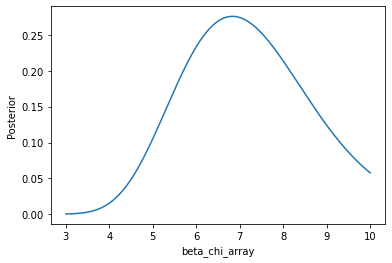

In [10]:
beta_chi_array=np.linspace(3,10,200)
posterior_beta=np.zeros_like(beta_chi_array)

# Number of effective samples for each events
neffinj=np.zeros_like(beta_chi_array)

for i,muu in enumerate(beta_chi_array):
    likelihood.parameters={'H0':70.,'Om0':0.3,
                           'alpha':1.,'beta':1.,'mmin':5.,'mmax':90.,'delta_m':4.,'mu_g':33.,'sigma_g':5.,'lambda_peak':0.03,
                          'gamma':2.7,'zp':2.,'kappa':3.,
                          'alpha_chi':1.9,'beta_chi':muu,'sigma_t':0.87,'csi_spin':0.76}
    posterior_beta[i]=likelihood.log_likelihood()
    
    # Storing the value of effective samples for the i-th event
    neffinj[i]=likelihood.injections.effective_detection_number(likelihood.injections.weights)
    
    
    
posterior_beta-=posterior_beta.max()
posterior_beta=xp.exp(posterior_beta)
posterior_beta/=trapz(posterior_beta,beta_chi_array)
plt.plot(beta_chi_array,posterior_beta)
plt.xlabel('beta_chi_array')
plt.ylabel('Posterior')

In [11]:
# Getting the name of the events with NeffPE < 20 and their actual number of samples used.

names=list(posterior_dict.keys())
N_ev = 0

for i in range(len(likelihood.test2)):
    if likelihood.test2[i]<=20:
        print(i,names[i],likelihood.test2[i])
        N_ev+=1
    
print('\n N_ev= ',N_ev)

7 GW190517_055101 12.10710457678713
32 GW191109_010717 6.655232041760295

 N_ev=  2


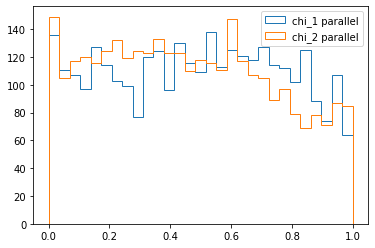

In [12]:
# Plot the distribution of chi_1 and chi_2 for these events

_=plt.hist(likelihood.posterior_parallel['chi_1'].reshape(likelihood.origin_shape)[20,:],bins=np.linspace(0,1,30),histtype='step',label='chi_1 parallel')
_=plt.hist(likelihood.posterior_parallel['chi_2'].reshape(likelihood.origin_shape)[20,:],bins=np.linspace(0,1,30),histtype='step',label='chi_2 parallel')

#_=plt.hist(posterior_dict['GW191127_050227'].posterior_data['chi_1'],bins=np.linspace(0,1,10),histtype='step',label='chi_1')
#_=plt.hist(posterior_dict['GW191127_050227'].posterior_data['chi_2'],bins=np.linspace(0,1,10),histtype='step',label='chi_2')

plt.legend()

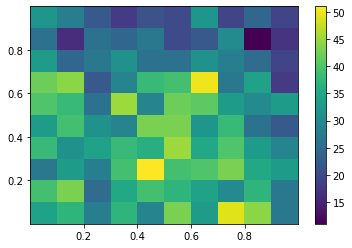

In [13]:
plt.hist2d(likelihood.posterior_parallel['chi_1'].reshape(likelihood.origin_shape)[20,:],likelihood.posterior_parallel['chi_2'].reshape(likelihood.origin_shape)[20,:])
plt.colorbar()


/Users/pierra/Desktop/These_ip2i/Cosmology_researches/icaroGW/icarogw_2/icarogwCAT_folder/icarogw/priors.py:438: RuntimeWarning: divide by zero encountered in log
  toret=(self.alpha-1.)*xp.log(x)+(self.beta-1.)*xp.log1p(-x)-xp.log(self.norm_fact)
/Users/pierra/Desktop/These_ip2i/Cosmology_researches/icaroGW/icarogw_2/icarogwCAT_folder/icarogw/priors.py:438: RuntimeWarning: divide by zero encountered in log1p
  toret=(self.alpha-1.)*xp.log(x)+(self.beta-1.)*xp.log1p(-x)-xp.log(self.norm_fact)


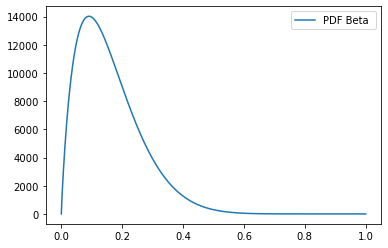

In [14]:
plt.plot(np.linspace(0,1,1000),likelihood.spin_wrap.beta_pdf.pdf(np.linspace(0,1,1000))*3194,label='PDF Beta ')
plt.legend()


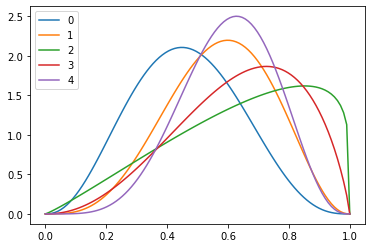

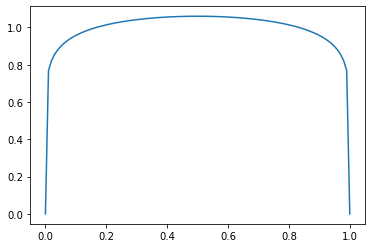

In [15]:
x = np.linspace(0,1,100)
al = np.random.rand(5)*5 +1
be = np.random.rand(5)*5 +1

pdf = scipy.stats.beta.pdf(x, 3, 6, loc=0, scale=1)

for i in range(len(be)):
    plt.plot(x,scipy.stats.beta.pdf(x, al[i], be[i], loc=0, scale=1),label=i)
plt.legend()
plt.show()

plt.plot(x,scipy.stats.beta.pdf(x, 1.1, 1.1, loc=0, scale=1))


# Posterior change of variable, from alpha beta to mu and sigma


The posteriors estimated are $p(\alpha|\Lambda)$ and $p(\beta|\Lambda)$, but for this analysis to be comparable with other studies, we need to draw the resulting posterior in terms of $\mu$ and $\sigma^2$.
Since we are dealing with posteriors distribution and not samples, we have to compute the Jacobian matrix corresponding to the change of variable from $\{\alpha, \beta \}$ to $\{\mu, \sigma^2\}$.

The derived posterior can be written : 

$$p(\mu,\sigma^2|\Lambda) = p(\alpha,\beta|\Lambda)|J_{\{\alpha,\beta \}} |, $$ 

where the joint posterior on $\{ \alpha,\beta\}$ can be re=written in terms of the 1D posterior (the ones estimated by IcaroGW), such that :

$$p(\alpha,\beta|\Lambda) = p(\alpha|\Lambda)p(\beta|\Lambda)C_{\alpha,\beta} .$$


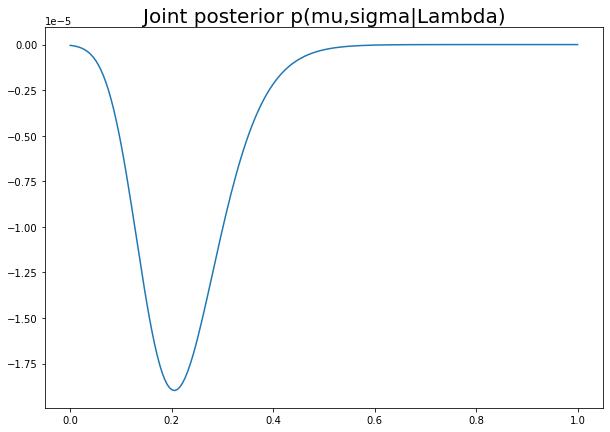

In [16]:
# Calculation of the Jacobian

def J_11(alpha,beta):
    return beta/np.power(alpha+beta,2)

def J_12(alpha,beta):
    return -alpha/np.power(alpha+beta,2)

def J_21(alpha,beta):
    
    #to_ret = (beta*np.power(alpha+beta,2)*(alpha+beta+1) -alpha*beta*((2*alpha +2*beta)*(alpha+beta+1) -np.power(alpha +beta,2) ) )/(np.power(alpha+beta,4)*np.power(alpha+beta+1,2))
    to_ret = (beta*(-2*np.power(alpha,2) -alpha*(beta+1) +beta*(beta+1)))/(np.power(alpha+beta,3) *np.power(alpha+beta+1,2))
    return to_ret

def J_22(alpha,beta):
    
    #to_ret = (alpha*np.power(alpha+beta,2)*(alpha+beta+1) -alpha*beta*((2*alpha +2*beta)*(alpha+beta+1) -np.power(alpha +beta,2) ) )/(np.power(alpha+beta,4)*np.power(alpha+beta+1,2))
    to_ret = (alpha*(np.power(alpha,2) -alpha*beta +alpha -beta*(2*beta +1)))/(np.power(alpha+beta,3) *np.power(alpha+beta+1,2))
    return to_ret

def det_J(alpha,beta):
    return J_11(alpha,beta)*J_22(alpha,beta) -J_12(alpha,beta)*J_21(alpha,beta)


pos_mu_var_chi = posterior_alpha*posterior_beta*det_J(alpha_chi_array,beta_chi_array)



plt.figure(figsize=(10,7))
plt.title('Joint posterior p(mu,sigma|Lambda)',fontsize=20)
plt.plot(np.linspace(0,1,200),pos_mu_var_chi)
plt.show()

# GAUSSIAN MODEL

## INJECTIONS

In [2]:
# import the injections
data=h5py.File('endo3_bbhpop-LIGO-T2100113-v12.hdf5')

# construct the cosmology prior
cosmo_ref=icarogw.cosmology.astropycosmology(10)
cosmo_ref.build_cosmology(Planck15)

# compute the ifar using all pipelines
ifarmax=np.vstack([data['injections'][key] for key in ['ifar_cwb', 'ifar_gstlal', 'ifar_mbta', 'ifar_pycbc_bbh', 'ifar_pycbc_hyperbank']])
ifarmax=np.max(ifarmax,axis=0)


#print('Keys of the injections = \n',data['injections'].keys(),'\n')
#print('Attrs of the injections = \n',list(data.attrs.items()),'\n')

In [3]:
# Convert carthesian spin to chi1,2 and cost1,2
chi_1, chi_2, cos_t_1, cos_t_2, chi_eff, chi_p = icarogw.conversions.cartestianspins2chis(data['injections/spin1x'][()],data['injections/spin1y'][()],data['injections/spin1z'][()],
                                           data['injections/spin2x'][()],data['injections/spin2y'][()],data['injections/spin2z'][()],
                                           data['injections/mass2_source'][()]/data['injections/mass1_source'][()])


# Create the injection dictionnary on masses, spins and distance
injections_dict={'mass_1':data['injections/mass1'][()],'mass_2':data['injections/mass2'][()],
                'luminosity_distance':data['injections/distance'][()],
                'chi_eff':chi_eff,'chi_p':chi_p}

print('\n chi eff =',injections_dict['chi_eff'])
print('\n chi p =',injections_dict['chi_p'])
print(injections_dict['chi_p'].max())


 chi eff = [ 0.61771715 -0.05037809 -0.02222202 ...  0.25964266 -0.18565789
 -0.07726001]

 chi p = [0.59846604 0.9185729  0.10187145 ... 0.3545062  0.6516595  0.6674807 ]
0.9978107


In [4]:
# Compute the total observation time 
time_O3 = (28519200/86400)/365 # Time of observation for O3

print('Observation Time =',time_O3,'yr')

# Set the maximum value for the spin magnitude
amax=0.998

print('Magnitude spin maximum =',amax)

Observation Time = 0.904337899543379 yr
Magnitude spin maximum = 0.998


### Computation of joint prior p(chi_p|chi_eff,q) (quite long)

In [5]:
# Compute the joint prior on chi_eff, chi_p
spinp=icarogw.conversions.joint_prior_from_isotropic_spins(data['injections/mass2_source'][()]/data['injections/mass1_source'][()],
                                                       amax,chi_eff,chi_p)


prior=np2cp(data['injections/mass1_source_mass2_source_sampling_pdf'][()]*data['injections/redshift_sampling_pdf'][()]*spinp)
prior*=icarogw.conversions.source2detector_jacobian(np2cp(data['injections/redshift'][()]),cosmo_ref)


Calculating p(chi_p|chi_eff,q): 100%|█████████████████████████████████████████████████████████████████| 284672/284672 [32:49<00:00, 144.56it/s]


In [6]:
# creates the posterior samples for the injections
inj=icarogw.injections.detector_injections_CBC(injections_dict,prior=prior,ntotal=data.attrs['total_generated'],Tobs=time_O3)

# update the ifar cut 
inj.update_cut(ifarmax>=4)
inj.cupyfy()

## POSTERIOR SAMPLES OF GWs

In [402]:
# Loading posterior samples (poss) from the real GWs events of all O3

poss=pickle.load(open('O3a_O3b_BBH_IFAR4.p','rb'))
posterior_dict={}

for ev in poss.keys():
    chi_eff = icarogw.conversions.chi_eff_from_spins(poss[ev]['chi_1'],poss[ev]['chi_2'],
                                                     poss[ev]['cost_1'],poss[ev]['cost_2'],
                                                     poss[ev]['mass_2_det']/poss[ev]['mass_1_det'])
    
    chi_p = icarogw.conversions.chi_p_from_spins(poss[ev]['chi_1'],poss[ev]['chi_2'],
                                                 poss[ev]['cost_1'],poss[ev]['cost_2'],
                                                 poss[ev]['mass_2_det']/poss[ev]['mass_1_det'])
    chi_p[chi_p>=amax]=amax*0.99

    if np.abs(chi_p).max() > 0.998 :
        print(ev,np.abs(chi_p).max(),np.abs(chi_eff).max())

    #chi_p[chi_p>=amax]=amax*0.99
    
    pos_dict={'mass_1':poss[ev]['mass_1_det'],'mass_2':poss[ev]['mass_2_det'],
             'luminosity_distance':poss[ev]['distance'],
             'right_ascension':poss[ev]['right_ascension'],'declination':poss[ev]['declination'],
             'chi_eff':chi_eff,'chi_p':chi_p}
    
    spinp=1.
    
    posterior_dict[ev]=icarogw.posterior_samples.posterior_samples(pos_dict,
                                                                prior=np.power(poss[ev]['distance'],2.)*spinp)


In [403]:
# Creation of all models for the priors terms (spin, mass, rate, cosmo)
cw=icarogw.wrappers.FlatLambdaCDM_wrap(zmax=10.)
mw=icarogw.wrappers.massprior_PowerLawPeak()
rw=icarogw.wrappers.rateevolution_Madau()
sw=icarogw.wrappers.spinprior_gaussian()

# Class containing the hierarchical likelihood for the CBC in source frame (saves all input requierements 
# for the analysis).
likelihood=icarogw.likelihood.hierarchical_likelihood_CBC_source(posterior_dict,inj,cw,mw,rw,spin_wrap=sw
                                                                  ,scale_free=True,neffINJ=200,neffPE=20.)

Using 3194 samples from each 52 posteriors


N_tot posterior samples/event =  5169
Number of used posterior samples/event =  3194


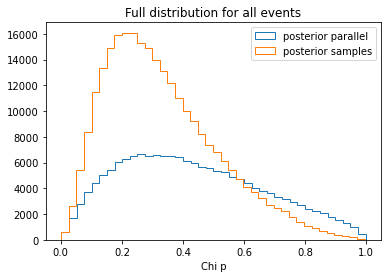

In [404]:
# Posterior values for GW-events 

print('N_tot posterior samples/event = ',len(chi_p)//52)
print('Number of used posterior samples/event = ', len(likelihood.posterior_parallel['chi_p'])//52)


plt.hist(likelihood.posterior_parallel['chi_p'],bins=40,histtype='step',label='posterior parallel')
plt.hist(chi_p,bins=40,histtype='step',label='posterior samples')

plt.title('Full distribution for all events')
plt.xlabel('Chi p')
plt.legend()

#print(likelihood.posterior_parallel.keys())

In [405]:
# Look for max values in GW events posterior samples
print('List of GW events with chi_p samples > a_max : ')

# List of GW-events with chi_p > amax

ev_names  = list(posterior_dict.keys())

for i in range(len(likelihood.posterior_parallel['chi_p'])):
    if likelihood.posterior_parallel['chi_p'][i] > 0.998:
        print('GW event : ' ,ev_names[i//3194],'number',i//3194)
        

List of GW events with chi_p samples > a_max : 


GW-event :  GW190413_134308
chi p max =  0.9979627034214983
Number of samples above amax =  0


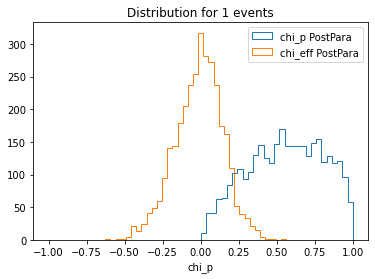

In [406]:
ev_number = 2

chi_p_value_event = likelihood.posterior_parallel['chi_p'].reshape(likelihood.origin_shape)[ev_number,:]
chi_eff_value_event = likelihood.posterior_parallel['chi_eff'].reshape(likelihood.origin_shape)[ev_number,:]

print('GW-event : ', ev_names[ev_number])
print('chi p max = ',chi_p_value_event.max())
print('Number of samples above amax = ',len(chi_p_value_event[chi_p_value_event>0.998]))

plt.hist(chi_p_value_event,bins=np.linspace(0,1,30),histtype='step',label='chi_p PostPara')
plt.hist(chi_eff_value_event,bins=np.linspace(-1,1,60),histtype='step',label='chi_eff PostPara')
plt.title('Distribution for 1 events')
plt.xlabel('chi_p')
plt.legend()



In [407]:
# Names of the GW-events 
#print(posterior_dict.keys())

# Access data from the dictionnary of posteriors
#print(posterior_dict['GW190620_030421'])


Text(0, 0.5, 'Posterior')

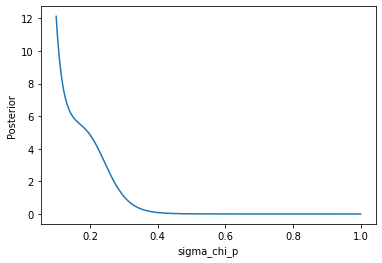

In [411]:
# On-grid analysis
mu_chi_eff_array=np.linspace(-.1,.3,200)
sigma_chi_eff_array = np.linspace(0.01,0.4,200)
sigma_chi_p_array=np.linspace(0.1,1,200)

posterior=np.zeros_like(sigma_chi_p_array)

for i,muu in enumerate(sigma_chi_p_array):
    likelihood.parameters={'H0':70.,'Om0':0.3,
                           'alpha':1.,'beta':1.,'mmin':5.,'mmax':90.,'delta_m':4.8,'mu_g':33.,'sigma_g':5.,'lambda_peak':0.03,
                          'gamma':2.7,'zp':2.,'kappa':3.,
                          'mu_chi_eff':0.06,'sigma_chi_eff':0.10,'mu_chi_p':0.21,'sigma_chi_p':muu,'rho':0.1}
    posterior[i]=likelihood.log_likelihood()
    
posterior-=posterior.max()
posterior=xp.exp(posterior)
posterior/=trapz(posterior,sigma_chi_p_array)
plt.plot(sigma_chi_p_array,posterior)
plt.xlabel('sigma_chi_p')
plt.ylabel('Posterior')

## To Do

So we have reasonable values for the posterior of both sigma parameters if we don't go to much exploring the very low range of the space ~10e-3 ! The same thing happens for very high value of the parameters space.
The amax value doesn't change a lot the posterior 

Try running the full analysis with the reasonable priors ranges ! 

and implement the alpha beta way of using the beta distribution.

And compare the above posterior with the Json file that RandP produced (see downloaded files on the bureau)

Working with alpha and beta and then perform an post analysis transfo to mu and sigma chi. (compute jacobian for the transformation that needs to be removed)

Try to understand the upper limit of mu and sigma if alpha and beta are >1 and what would be the upper limit for alpha and beta too ? 5 ? 10? 

Put amax = 1 to avoid low cut off for sigma

In [395]:
indice = np.where(posterior == max(posterior))
print('Peaked at',sigma_chi_p_array[indice])

Peaked at [0.13145729]


In [396]:
# Getting the name of the events with NeffPE < 20 and their actual number of samples used.

names=list(posterior_dict.keys())
N_ev = 0


for i in range(len(likelihood.test2)):
    #print(names[i],'',likelihood.test2[i])
    
    if likelihood.test2[i] <= 100: # test2 = NeffPE
        
        print(i,names[i],likelihood.test2[i])
        N_ev+=1
    
print('\n N_ev= ',N_ev)

7 GW190517_055101 51.7724451297459

 N_ev=  1


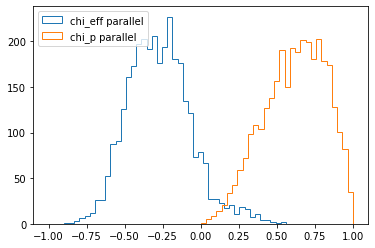

In [397]:
# Plot the distribution of chi_1 and chi_2 for these events

_=plt.hist(likelihood.posterior_parallel['chi_eff'].reshape(likelihood.origin_shape)[32,:],bins=np.linspace(-1,1,60),histtype='step',label='chi_eff parallel')
_=plt.hist(likelihood.posterior_parallel['chi_p'].reshape(likelihood.origin_shape)[32,:],bins=np.linspace(0,1,30),histtype='step',label='chi_p parallel')

#_=plt.hist(posterior_dict['GW191127_050227'].posterior_data['chi_1'],bins=np.linspace(0,1,10),histtype='step',label='chi_1')
#_=plt.hist(posterior_dict['GW191127_050227'].posterior_data['chi_2'],bins=np.linspace(0,1,10),histtype='step',label='chi_2')

plt.legend()

Text(0, 0.5, 'chi_p')

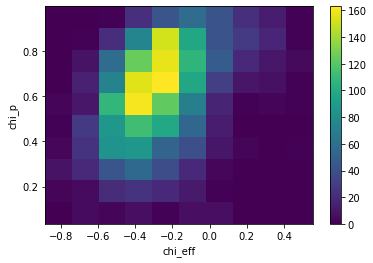

In [398]:
# 2D histogramme of chi eff and chi p 

plt.hist2d(likelihood.posterior_parallel['chi_eff'].reshape(likelihood.origin_shape)[32,:],likelihood.posterior_parallel['chi_p'].reshape(likelihood.origin_shape)[32,:])
plt.colorbar()
plt.xlabel('chi_eff')
plt.ylabel('chi_p')

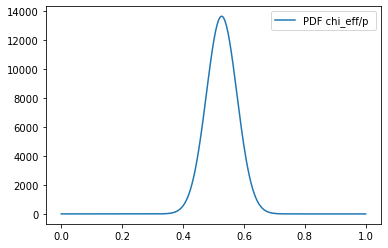

In [399]:
# Plot of the PDF for the spins 

plt.plot(np.linspace(0,1,1000),likelihood.spin_wrap.pdf_evaluator.pdf(np.linspace(-1,1,1000),np.linspace(0,1,1000))*3194,label='PDF chi_eff/p ')
plt.legend()

In [400]:
likelihood.spin_wrap.pdf_evaluator.pdf(np.linspace(-1,1,1000),np.linspace(0,1,1000))*3194
print(np.shape(likelihood.spin_wrap.pdf_evaluator.pdf(np.linspace(-1,1,1000),np.linspace(0,1,1000))*3194))

(1000,)


In [241]:
len(likelihood.test)

52

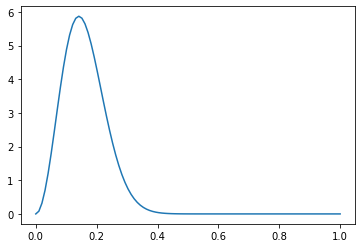

In [386]:
from scipy.stats import maxwell
plt.plot(np.linspace(0,1,100),maxwell.pdf(x,0,0.1))